# hw04

 获取苹果公司从2014年1月1日到今天的股票数据

为了更加切合实际，选取的是sh510300ETF近3年的数据

## 1）画出股票数据的折线图

In [7]:
import requests
import json
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行
import matplotlib.pyplot as plt
%matplotlib inline
# 支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [1]:
def get_hist_k_data(code, datalen, verbose=False, plot=False):
    r = requests.get('http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol={}&scale=240&ma=no&datalen={}'.format(code, datalen))
    rs = r.text
    cols_num = ['open', 'high', 'low', 'close']
    cols = ['day', 'volume'] + cols_num
    for c in cols:
        rs = rs.replace(c, '"{}"'.format(c))
    df1 = pd.DataFrame(json.loads(rs))
    df1.loc[:, cols_num] = df1.loc[:, cols_num].applymap(float)
    df1.loc[:, 'day'] = pd.to_datetime(df1.day)
    df1.index = df1.day
    if verbose:
        print(df1.head(2))
        print(df1.tail(2))
    if plot:
        df1.close.plot()
        
    return df1

In [2]:
code = 'sh510300'
datalen = 250*3

            close        day   high    low   open    volume
day                                                        
2017-01-11  3.386 2017-01-11  3.422  3.385  3.405  94705340
2017-01-12  3.369 2017-01-12  3.395  3.366  3.386  84000935
            close        day   high    low   open     volume
day                                                         
2020-02-12  3.971 2020-02-12  3.977   3.93  3.939  290783451
2020-02-13   3.95 2020-02-13  3.985  3.938   3.97  325961046


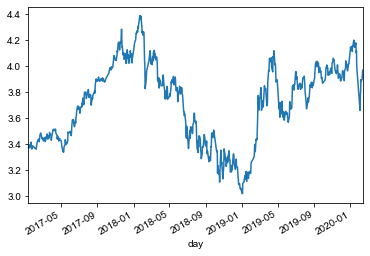

In [5]:
df = get_hist_k_data(code, datalen, True, True)

## 2）计算对数收益率



In [24]:
df['log_return'] = (df.close/df.close.shift(1)).map(np.log)

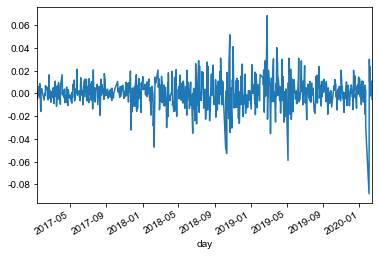

In [25]:
df.log_return.plot()

## 3）计算历史波动率

In [28]:
df['波动率'] = df.log_return.rolling(252).std()/np.sqrt(252)

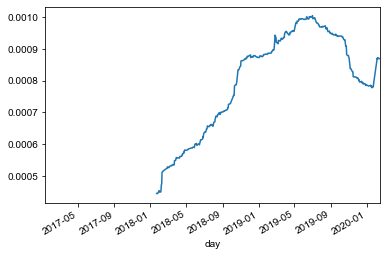

In [29]:
df.波动率.plot()